In [1]:
import pandas as pd             # data package
import matplotlib.pyplot as plt # graphics 
import datetime as dt
import numpy as np
from census import Census # This is new...
from scipy.stats.mstats import gmean

import requests, io             # internet and input tools  
import zipfile as zf            # zip file tools 
import os  

#import weightedcalcs as wc
#import numpy as np

import pyarrow as pa
import pyarrow.parquet as pq

https://www.imf.org/external/np/sta/tegppi/ch20.pdf

This .pdf plug in the different chapters gives a good idea about stuff. 20 talks about elemetry indicies, so say do that at a low level, then when you aggregate do something like a tornqvist of fisher

I'm going to follow Broda and Weinstein (2006) https://web.stanford.edu/~klenow/Broda_and_Weinstein.pdf in setting things up.

The first question is level of aggregation and what a variety is. I'm going to do this at the HS4 level. What this means is then each HS10 product X country within the HS4 code is a variety. 

In [2]:
def make_expenditure_shares(df):
    
    df["S_gct"] = df["CON_VAL_MO"] / df["CON_VAL_MO"].sum()
    
    df["log_S_gct"] = np.nan
    
    df["log_S_gct"][df["CON_VAL_MO"]>0] = np.log( df["S_gct"][df["CON_VAL_MO"]>0] )
     
    return df

In [4]:
my_key = "&key=34e40301bda77077e24c859c6c6c0b721ad73fc7"
# This is my key. I'm nice and I have it posted. If you will be doing more with this
# please get your own key!

In [631]:
end_use = "hs?get=CON_VAL_MO,CTY_NAME,I_COMMODITY_SDESC,CON_QY1_MO,UNIT_QY1"

url = "https://api.census.gov/data/timeseries/intltrade/imports/" + end_use 
url = url + my_key + "&time==from+2013-01" + "&COMM_LVL=HS10" + "&I_COMMODITY=44*" + "&CTY_CODE=1220"

# This will grab all products that fall under the "non-alloyed unwrought aluminum"
# and will have the quantity values that all appear to be in Killograms

r = requests.get(url) 
    
print(r)
    
df = pd.DataFrame(r.json()[1:]) # This then converts it to a dataframe
    # Note that the first entry is the labels

df.columns = r.json()[0]

df.time = pd.to_datetime(df.time, format="%Y-%m")

df["CON_VAL_MO"] = df["CON_VAL_MO"].astype(float)

df["CON_QY1_MO"] = df["CON_QY1_MO"].astype(float)

df = df[df["CON_QY1_MO"] > 0]

df["price"] = df.CON_VAL_MO / df.CON_QY1_MO

<Response [200]>


In [632]:
df.set_index(["time", "I_COMMODITY"], inplace = True)

df.sort_index()

df.head()

,,CON_VAL_MO,CTY_NAME,I_COMMODITY_SDESC,CON_QY1_MO,UNIT_QY1,COMM_LVL,CTY_CODE,price
time,I_COMMODITY,,,,,,,,
2018-10-01,4401110000,372580.0,CANADA,"FUEL WOOD, LOGS, BILLTS, TWGS, FAGGOTS, CONIFE...",1157968.0,KG,HS10,1220,0.321753
2018-11-01,4401110000,363864.0,CANADA,"FUEL WOOD, LOGS, BILLTS, TWGS, FAGGOTS, CONIFE...",1079533.0,KG,HS10,1220,0.337057
2018-12-01,4401110000,363931.0,CANADA,"FUEL WOOD, LOGS, BILLTS, TWGS, FAGGOTS, CONIFE...",1162829.0,KG,HS10,1220,0.312970
2019-01-01,4401110000,342552.0,CANADA,"FUEL WOOD, LOGS, BILLTS, TWGS, FAGGOTS, CONIFE...",1117392.0,KG,HS10,1220,0.306564
2019-02-01,4401110000,253231.0,CANADA,"FUEL WOOD, LOGS, BILLTS, TWGS, FAGGOTS, CONIFE...",797529.0,KG,HS10,1220,0.317519


In [633]:
def common_set_price(df, dfall):
    
    outdf = pd.DataFrame()
    
    if df.index.get_level_values(0)[0].year == 2013:
        
        log_pt = np.nan
        
        log_pt1 = np.nan
        
        ngoods = np.nan
        
        outdf["delta_log_pt"] = [log_pt - log_pt1]
        
        outdf["ngoods"] = [ngoods]
        
        return outdf
    
    footime = df.index.get_level_values(0)[0]
    # gets the current time
        
    footime2 = dt.datetime(2013, footime.month, 1)
    # a year back
    
    bar = dfall.loc[footime2]
    
    common_set_index = bar.index.intersection(df.index.get_level_values(1))
    
    cxpt = df.loc[(footime, common_set_index),:].CON_VAL_MO.to_numpy()
    
    cxpt1 = dfall.loc[(footime2, common_set_index),:].CON_VAL_MO.to_numpy()
    
    xpt = df.loc[footime].CON_VAL_MO.to_numpy()
    
    xpt1 = dfall.loc[footime2].CON_VAL_MO.to_numpy()

    pt = df.loc[(footime, common_set_index),:].price.to_numpy()
    
    pt1 = dfall.loc[(footime2, common_set_index),:].price.to_numpy()
    
    #####################################################################################
    
    price_index, wt = sato_varita(pt, pt1, cxpt, cxpt1)
    
    lambda_t, lambda_t1, ratio_lambda = feenstra_adjustment(cxpt,cxpt1,xpt,xpt1)
        
    #####################################################################################    
    sigma = 4
    
    ngoods= df.loc[(footime, common_set_index),:].price.count()
    
    outdf["delta_log_pt"] = [price_index]
    
    outdf["delta_log_pt_adj"] = [(price_index + (1/(sigma - 1)) * np.log(ratio_lambda))]
    
    outdf["ngoods"] = [ngoods]
    
    outdf["feenstra_adj"] = [ratio_lambda]
                
    return outdf

In [634]:
def feenstra_adjustment(cxpt,cxpt1,xpt,xpt1):
    
    lambda_t = cxpt.sum() / xpt.sum()
    # this is equation 11 in Broda Weinstein
    # take sum of common set / sum of all
    
    lambda_t1 = cxpt1.sum() / xpt1.sum()
    
    ratio_lambda = lambda_t / lambda_t1
    
    return lambda_t, lambda_t1, ratio_lambda

In [635]:
def sato_varita(pt,pt1,xpt,xpt1):
    
    if xpt1.size != xpt.size:
        
        print("common set not common")
        
        return np.nan
    
    st = xpt / xpt.sum() # these are shares over common set
    
    st1 = xpt1 / xpt1.sum()
    
    log_st = np.log(st)
    
    log_st1 = np.log(st1)
    
    wtnum = ((st - st1) / (log_st - log_st1)) 
    
    wtden = wtnum.sum()
    
    wt = wtnum / wtden # equation 10 in Broda Weinstain
    
    price_index = (wt * (np.log(pt) - np.log(pt1))).sum()
    
    return price_index, wt

In [636]:
grp = df.groupby(["time"])

ptest = grp.apply(lambda x: common_set_price(x, df))

ptest.reset_index(inplace = True)

ptest.drop(["level_1"], inplace = True, axis = 1)

ptest.set_index(["time"], inplace = True)

<AxesSubplot:xlabel='time'>

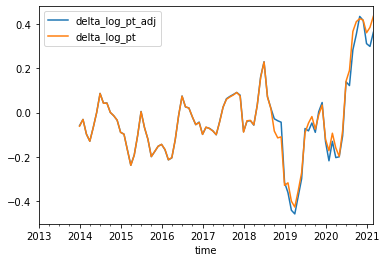

In [637]:
ptest[["delta_log_pt_adj", "delta_log_pt"]].plot()

In [626]:
ptest

,delta_log_pt,ngoods,delta_log_pt_adj,feenstra_adj
time,,,,
2013-01-01,NaN,NaN,NaN,NaN
2013-02-01,NaN,NaN,NaN,NaN
2013-03-01,NaN,NaN,NaN,NaN
2013-04-01,NaN,NaN,NaN,NaN
2013-05-01,NaN,NaN,NaN,NaN
...,...,...,...,...
2020-11-01,0.386217,238.0,0.385473,0.997771
2020-12-01,0.447155,222.0,0.447217,1.000185
2021-01-01,0.595066,238.0,0.595042,0.999928


In [627]:
ptest.loc[:"2018-6"].mean()

delta_log_pt          0.009485
ngoods              192.796296
delta_log_pt_adj      0.009667
feenstra_adj          1.000548
dtype: float64

In [628]:
ptest.loc["2018-6":].mean()

delta_log_pt          0.116781
ngoods              192.029412
delta_log_pt_adj      0.116650
feenstra_adj          1.003482
dtype: float64

In [630]:
df.sort_index()

CON_VAL_MO CTY_NAME  \
time       I_COMMODITY                        
2013-01-01 4401220000      15215.0   CANADA   
           4401310000    2844669.0   CANADA   
           4401392000      13521.0   CANADA   
           4401394010      87861.0   CANADA   
           4401394020    2633300.0   CANADA   
...                            ...      ...   
2021-03-01 4421998800      11841.0   CANADA   
           4421999300     106460.0   CANADA   
           4421999400    2678252.0   CANADA   
           4421999730    2466869.0   CANADA   
           4421999780   16401612.0   CANADA   

                                                        I_COMMODITY_SDESC  \
time       I_COMMODITY                                                      
2013-01-01 4401220000           WOOD IN CHIPS OR PARTICLES, NONCONIFEROUS   
           4401310000                                        WOOD PELLETS   
           4401392000   ARTIFICIAL FIRE LOGS, COMPOSED OF WAX AND SAWDUST   
           4401394010                           SAWDUST, NOT AGGLOMERATED   
           4401394020           WOOD SHAVING, WHETHER OR NOT AGGLOMERATED   
...                                                                   ...   
2021-03-01 4421998800                               CANOE PADDLES OF WOOD   
           4421999300   THEATRICAL/BALLET SCENERY AND PROPERTIES, OF WOOD   
           4421999400                            EDGE-GLUED LUMBER, NESOI   
           4421999730                              BURIAL CASKETS OF WOOD   
           4421999780                             ARTICLES OF WOOD, NESOI   

                        CON_QY1_MO UNIT_QY1 COMM_LVL CTY_CODE       price  
time       I_COMMODITY                                                     
2013-01-01 4401220000         20.0        T     HS10     1220  760.750000  
           4401310000   13563256.0       KG     HS10     1220    0.209733  
           4401392000      39634.0       KG     HS10     1220    0.341146  
           4401394010     275408.0       KG     HS10     1220    0.319021  
           4401394020   12531458.0       KG     HS10     1220    0.210135  
...                            ...      ...      ...      ...         ...  
2021-03-01 4421998800        149.0       NO     HS10     1220   79.469799  
           4421999300      19694.0       KG     HS10     1220    5.405707  
           4421999400       2884.0       M3     HS10     1220  928.658807  
           4421999730       3320.0       NO     HS10     1220  743.032831  
           4421999780   20370111.0       KG     HS10     1220    0.805180  

[23685 rows x 8 columns]